In [1]:
import lbforaging
import numpy as np
import time, os
import matplotlib.pyplot as plt
from tqdm import tqdm
from games.foraging import Foraging
from agents.iql_agent import IQLAgent, IQLAgentConfig
from agents.jal_am_agent import JALAgent, JALAgentConfig
from nbconvert import HTMLExporter
import nbformat

In [2]:

game_config = [
        "Foraging-5x5-2p-1f-v3",
        "Foraging-8x8-2p-1f-v3",
        "Foraging-5x5-3p-1f-v3",
        "Foraging-5x5-3p-1f-coop-v3",
    ]
# Configuración básica
config = {
    'game': game_config[3],  # Cambia el juego aquí
    'iql': IQLAgentConfig(alpha=0.1, min_epsilon=0.01, epsilon_decay=0.99995, max_t=10000, seed=1),
    'jal': JALAgentConfig(alpha=0.1, min_epsilon=0.05, epsilon_decay=0.99995, max_t=10000, seed=1),
    'train_config': {
        'episodes': 100,  # Reducido para pruebas rápidas
        'iterations': 100,
    },
    'eval_config': {
        'episodes': 50,
    },
    'agent_types': {
        'agent_0': 'iql',
        'agent_1': 'iql'
    }
}

In [3]:
def save_notebook_to_html(notebook_path="simple_test.ipynb"):
    """Guarda el notebook como HTML"""
    exporter = HTMLExporter()
    notebook = nbformat.read(notebook_path, as_version=4)
    html, _ = exporter.from_notebook_node(notebook)
    
    os.makedirs("notebook_exports", exist_ok=True)
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    output_path = f"notebook_exports/simple_experiment_{timestamp}.html"
    
    with open(output_path, "w") as f:
        f.write(html)
    
    return output_path

# Función simplificada para jugar un episodio
def play_episode(game, agents, verbose=False, render=False):
    game.reset()
    step_count = 0
    for agent in game.agents:
        agents[agent].reset()

    if verbose:
        print(f"Step: {step_count}")
        for agent in game.agents:
            print(f"Agent {agent} observe: {game.observe(agent)}")
    
    cum_rewards = {agent: 0.0 for agent in game.agents}
    
    while not game.done():
        step_count += 1
        actions = {}
        for agent in game.agents:
            actions[agent] = agents[agent].action()
        
        game.step(actions)
        
        for agent in game.agents:
            cum_rewards[agent] += game.reward(agent)
            agents[agent].update()
            
        if verbose:
            print(f"Step: {step_count}")
            for agent in game.agents:
                print(f"Agent {agent} observe: {game.observe(agent)}")

                # Print actions, rewards and next state if verbose is enabled
        if verbose:
            print(f"Step: {step_count}")
            for agent in game.agents:
                print(f"Agent {agent} action: {actions[agent]} - {game.action_set[actions[agent]]}")
                print(f"Agent {agent} reward: {game.reward(agent)}")
                print(f"Agent {agent} observe: {game.observe(agent)}")
        
        if render:
            game.render()
            time.sleep(0.1)

    
    return cum_rewards

# Función simplificada de entrenamiento
def simple_train(game, agents, train_config):
    
    stats = {
        'average_rewards': {agent: [] for agent in game.agents},
        'episode_rewards': {agent: [] for agent in game.agents},
        'actions_taken': {agent: [] for agent in game.agents},
    }
    
    for i in range(train_config['iterations']):
        iteration_rewards = {agent: 0.0 for agent in game.agents}
        
        for e in range(train_config['episodes']):
            rewards = play_episode(game, agents, verbose=False)
            
            for agent in game.agents:
                stats['episode_rewards'][agent].append(rewards[agent])
                iteration_rewards[agent] += rewards[agent]
                stats['actions_taken'][agent].append(agents[agent].last_action)

                
        
        for agent in game.agents:
            stats['average_rewards'][agent].append(iteration_rewards[agent] / train_config['episodes'])
    return stats

# Función para visualizar resultados
def plot_simple_results(stats):
    plt.figure(figsize=(12, 6))
    for agent, rewards in stats['average_rewards'].items():
        plt.plot(rewards, label=f"Agent {agent}")
    plt.title("Training Progress")
    plt.xlabel("Iteration")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    

# Ejecución principal
def run_simple_experiment(config):
    game = Foraging(config=config['game'], seed=config.get('seed', 1))
    agents = {}
    
    for agent_id in game.agents:
        agent_type = config['agent_types'].get(agent_id, 'iql')
        if agent_type == 'jal':
            agents[agent_id] = JALAgent(game, agent_id, config['iql'])
        else:
            agents[agent_id] = IQLAgent(game, agent_id, config['iql'])

    game.reset()
    for agent in game.agents:
        print(f"Agent: {agent}")
        print(f"Observation: {game.observe(agent)}")
        
    print("Starting training...")
    train_stats = simple_train(game, agents, config['train_config'])
    
    print("\nTraining completed. Showing results...")
    plot_simple_results(train_stats)
    
    print("\nRunning evaluation...")
    eval_rewards = {agent: [] for agent in game.agents}
    actions_taken = {agent: [] for agent in game.agents}
    for agent in game.agents:
        agents[agent].learn = False  # Desactivar el aprendizaje para la evaluación
    for _ in range(config['eval_config']['episodes']):
        rewards = play_episode(game, agents, render=False)
        for agent in rewards:
            eval_rewards[agent].append(rewards[agent])

    
    print("\nEvaluation results:")
    for agent, rewards in eval_rewards.items():
        print(f"Agent {agent}: Avg reward = {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")

/usr/local/Caskroom/miniconda/base/envs/pettingzoo_games/lib/python3.11/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/Caskroom/miniconda/base/envs/pettingzoo_games/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:275: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


Agent: agent_0
Observation: [3. 1. 4. 0. 0. 2. 4. 1. 1. 4. 2. 1.]
Agent: agent_1
Observation: [3. 1. 4. 4. 1. 1. 0. 0. 2. 4. 2. 1.]
Agent: agent_2
Observation: [3. 1. 4. 4. 2. 1. 0. 0. 2. 4. 1. 1.]
Starting training...

Training completed. Showing results...


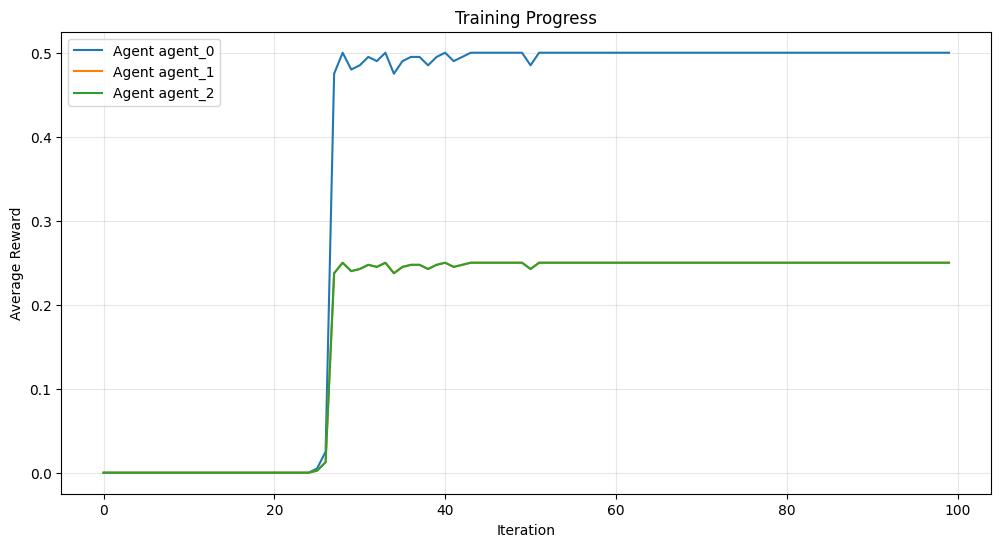


Running evaluation...

Evaluation results:
Agent agent_0: Avg reward = 0.50 ± 0.00
Agent agent_1: Avg reward = 0.25 ± 0.00
Agent agent_2: Avg reward = 0.25 ± 0.00


In [4]:
# Ejecutar el experimento
run_simple_experiment(config)



In [17]:
save_notebook_to_html()

'notebook_exports/simple_experiment_20250522-092951.html'